# updated version of RD900 analysis to detect region differences using raw reads

In [36]:
import os, io, glob, subprocess
from importlib import reload
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from snpgenie import tools, aligners, app, trees, plotting

In [2]:
read_data = pd.read_csv('../genomes_data.csv')
path = '/storage/elena_data'
read_data[-5:]

,ACCESSION,PAIRED,LINEAGE,ORIGIN,BIOPROJECT,BIOSAMPLE,Reads lenght (bp),LINK1,LINK2,REFERENCE
58,SRR7983756,yes,BCG-Danish,NaN,PRJNA494982,SAMN10219708,100,NaN,NaN,Borgers et al. 2019
59,ERR766257,yes,BCG-Pasteur,NaN,PRJEB8560,SAMEA3257671,100,NaN,NaN,King Abdullah University of Science and Techno...
60,ERR766251,yes,BCG-Japan,NaN,PRJEB8560,SAMEA3257669,100,NaN,NaN,King Abdullah University of Science and Techno...
61,ERR766266,yes,BCG-Russia,NaN,PRJEB8560,SAMEA3257674,100,NaN,NaN,King Abdullah University of Science and Techno...
62,ERR766254,yes,BCG-Moreau,NaN,PRJEB8560,SAMEA3257670,100,NaN,NaN,King Abdullah University of Science and Techno...


In [20]:
from BCBio import GFF
rec = list(GFF.parse('RD900MAF.gff'))[0]

#remove gene features for plotting
rec.features = [f for f in rec.features]
rec.features

[SeqFeature(FeatureLocation(ExactPosition(6156), ExactPosition(6981), strand=-1), type='gene'),
 SeqFeature(FeatureLocation(ExactPosition(782), ExactPosition(2663), strand=-1), type='gene', id='gene:BQ2027_MB1297C'),
 SeqFeature(FeatureLocation(ExactPosition(1611), ExactPosition(1772), strand=-1), type='domain', id='gene:pknH1_proline'),
 SeqFeature(FeatureLocation(ExactPosition(2906), ExactPosition(5303), strand=-1), type='gene', id='gene:BQ2027_MB1297CA'),
 SeqFeature(FeatureLocation(ExactPosition(5313), ExactPosition(6981), strand=-1), type='gene', id='gene:BQ2027_MB1297CB'),
 SeqFeature(FeatureLocation(ExactPosition(6080), ExactPosition(6153), strand=-1), type='domain', id='gene:pknH2_proline'),
 SeqFeature(FeatureLocation(ExactPosition(6394), ExactPosition(6396), strand=-1), type='gene', id='gene:'),
 SeqFeature(FeatureLocation(ExactPosition(7321), ExactPosition(8514), strand=-1), type='gene', id='gene:_2'),
 SeqFeature(FeatureLocation(ExactPosition(1725), ExactPosition(2663), str

In [ ]:
args = {'threads':20, 'outdir': 'snpgenie_results', 'labelsep':'-',  
        'input':['/storage/elena_data/'],        
        'reference': 'RD900MAF.fa', #'gb_file':'RD900MAF.gb',
        'overwrite':False,
        'filters' : 'QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35'
        }
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [21]:
samples = pd.read_csv('snpgenie_results/summary.csv')
samples = samples.merge(read_data,left_on='sample',right_on='ACCESSION')
samples = samples.sort_values('LINEAGE')

## plot the coverage over the region for each sample

In [78]:
def get_coverage(bam_file, chr, start, end):
    cmd = 'samtools mpileup {b} --min-MQ 10 -f RD900MAF.fa -r {c}:{s}-{e}'.format(c=chr,s=start,e=end,b=bam_file)
    #print(cmd)
    temp = subprocess.check_output(cmd, shell=True)    
    df=pd.read_csv(io.BytesIO(temp), sep='\t', names=['chr','pos','base','coverage','q','c'])
    return df
    
for n,r in list(samples.iterrows())[40:41]:     
     get_coverage(r.bam_file,'RD900MAF',1,len(rec.seq))  

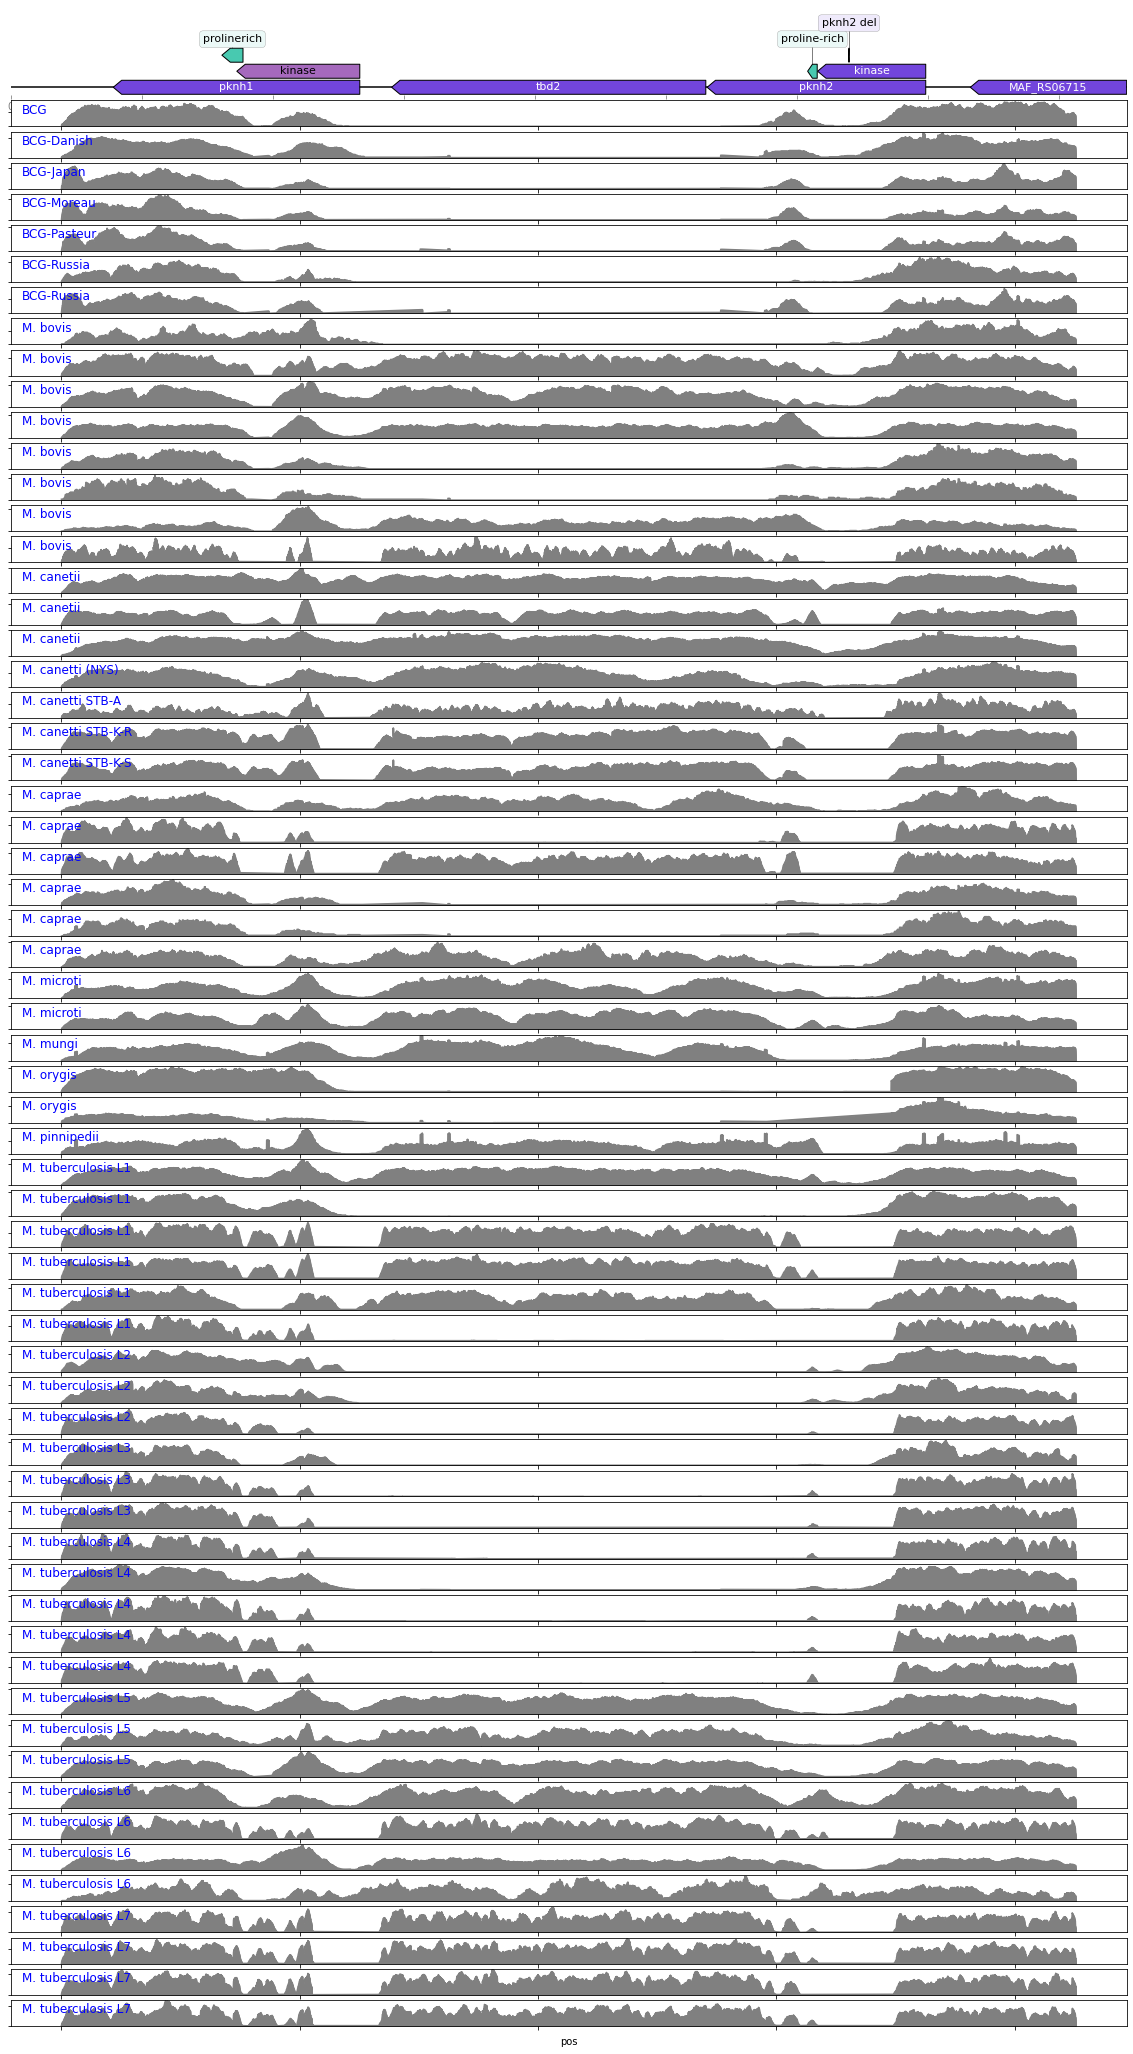

In [79]:
from dna_features_viewer import GraphicFeature, GraphicRecord
from dna_features_viewer import BiopythonTranslator

graphic_record = BiopythonTranslator().translate_record(rec)
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20,40))
gs = GridSpec(70, 1, figure=fig)
ax1=fig.add_subplot(gs[:3,0])
graphic_record.plot(ax=ax1)
i=3
for n,r in list(samples.iterrows()):#[40:60]:
    ax=fig.add_subplot(gs[i,0])
    df = get_coverage(r.bam_file,'RD900MAF',1,len(rec.seq))
    #bins=range(0,max(df.coverage),int(max(df.coverage)/10))
    #df['binned']=np.searchsorted(bins, df.coverage.values)
    df.plot(x='pos',y='coverage',ax=ax,kind='area',color='gray',legend=False)
    label=r.LINEAGE
    ax.text(.01,.5,label,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    i+=1
#plt.tight_layout()

## this code tries to automatically detect presence of regions from the coverage

In [ ]:
coords = [(f.id,int(f.location.start),int(f.location.end)) for f in rec.features]
coords

In [154]:
def detect_coverage(file, ref, coords):
    """get the average sequencing depth"""
    
    from io import StringIO
    from pyfaidx import Fasta
    cmd = 'zcat %s | paste - - - - | cut -f2 | wc -c' %file
    tmp = subprocess.check_output(cmd,shell=True)
    rg = Fasta(ref)
    avdepth = int(tmp)*2/len(rg)
    #print (avdepth)
    #cmd = 'samtools coverage --min-BQ 0 %s' %file    
    #tmp = subprocess.check_output(cmd,shell=True)
    #s = pd.read_csv(StringIO(tmp.decode()),sep='\t')   
    #s['ratio'] = s.meandepth/avdepth
       
    df = get_coverage(file,'RD900MAF',1,len(rec.seq)).set_index('pos')
    res=[]
    for c in coords:
        start,end=c[1],c[2]
        x = df.loc[start:end]        
        x = (c[0],x.coverage.sum()/(end-start))
        res.append(x)        
    return pd.DataFrame(res,columns=['region','coverage'])

coords = [('pknH1', 782, 2663),
 ('pknH1_proline', 1611, 1772),
 ('tbd2', 2906, 5303),
 ('pknH2', 5313, 6981),
 ('pknH2_proline', 6080, 6153), 
 ('pknH1_kinase', 1725, 2663)]

#detect_coverage('snpgenie_results/mapped/ERR015616.bam','RD900MAF.fa',coords)

In [162]:
M=[] 
for i,r in list(samples.iterrows()):
    res = detect_coverage(r.bam_file,'RD900MAF.fa',coords)
    res['lineage'] = r.LINEAGE
    res['sample'] = r.ACCESSION
    M.append(res)
M=pd.concat(M)

In [163]:
P = pd.pivot_table(M,index=['sample','lineage'],columns=['region'],values='coverage')
P[P<1]=0
P[P>1]=1
P

,region,pknH1,pknH1_kinase,pknH1_proline,pknH2,pknH2_proline,tbd2
sample,lineage,,,,,,
ERR015598,M. canetti STB-A,1.0,1.0,1.0,1.0,1.0,1.0
ERR015616,M. tuberculosis L2,1.0,1.0,1.0,1.0,0.0,0.0
ERR017778,BCG-Russia,1.0,1.0,0.0,1.0,1.0,0.0
ERR017801,M. tuberculosis L5,1.0,1.0,1.0,1.0,1.0,1.0
ERR027294,M. microti,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
SRR5216693,M. bovis,1.0,1.0,0.0,1.0,1.0,1.0
SRR650219,M. caprae,1.0,1.0,0.0,1.0,1.0,1.0
SRR6650709,M. canetti (NYS),1.0,1.0,1.0,1.0,1.0,1.0


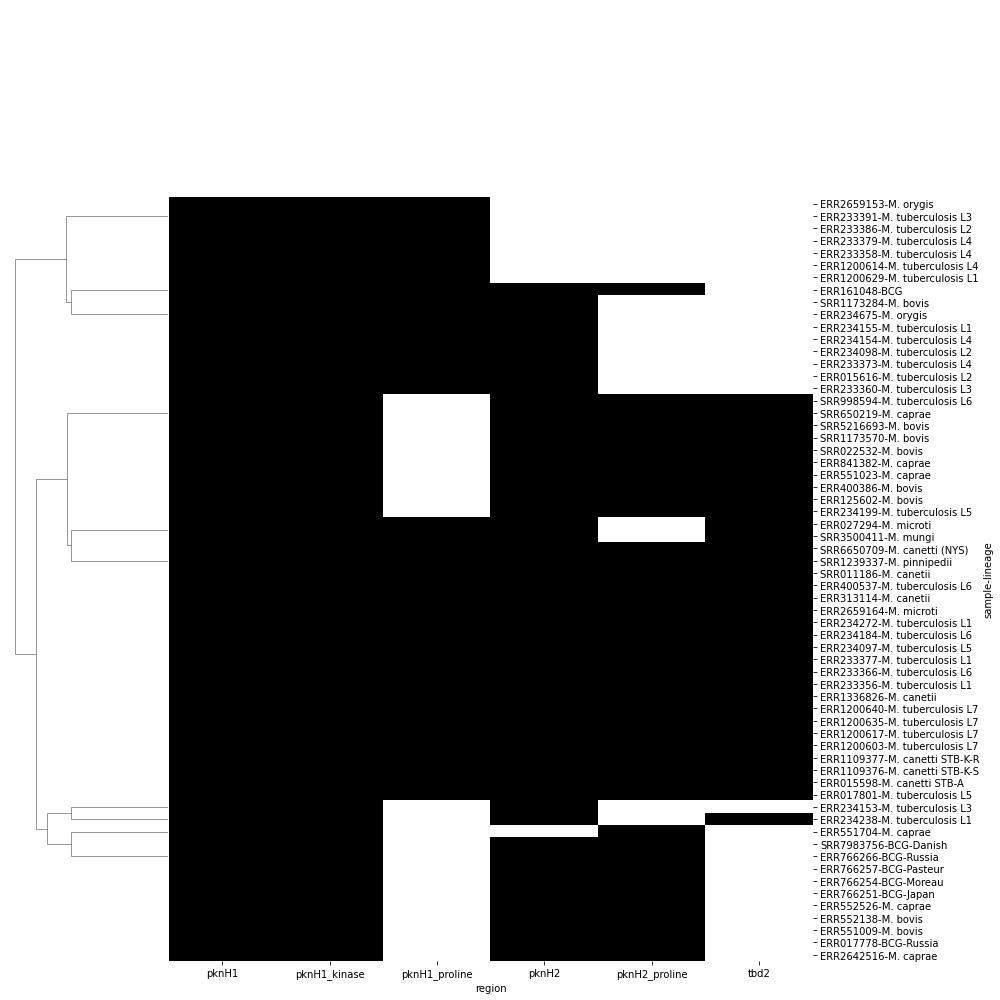

In [166]:
cm=sns.clustermap(P,col_cluster=False,cmap='gray_r',figsize=(14,14),
                  xticklabels=True,yticklabels=True)
cm.cax.set_visible(False)